# CNC Mill Tool Wear
- https://www.kaggle.com/shasun/tool-wear-detection-in-cnc-mill
- Predict "Machining_Process"

In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split

,X1_ActualPosition,X1_ActualVelocity,X1_ActualAcceleration,X1_CommandPosition,X1_CommandVelocity,X1_CommandAcceleration,X1_CurrentFeedback,X1_DCBusVoltage,X1_OutputCurrent,X1_OutputVoltage,...,S1_OutputCurrent,S1_OutputVoltage,S1_OutputPower,S1_SystemInertia,M1_CURRENT_PROGRAM_NUMBER,M1_sequence_number,M1_CURRENT_FEEDRATE,Machining_Process,feedrate,clamp_pressure
0,198.0,0.0,0.00,198.0,0.0,0.000000,0.18,0.0207,329.0,2.77,...,329.0,0.0,6.960000e-07,12.0,1.0,0.0,50.0,7,6,4.0
1,198.0,-10.8,-350.00,198.0,-13.6,-358.000000,-10.90,0.1860,328.0,23.30,...,328.0,0.0,-5.270000e-07,12.0,1.0,4.0,50.0,7,6,4.0
2,196.0,-17.8,-6.25,196.0,-17.9,-0.000095,-8.59,0.1400,328.0,30.60,...,328.0,0.0,9.100000e-07,12.0,1.0,7.0,50.0,7,6,4.0


(25286, 50)


<AxesSubplot:>

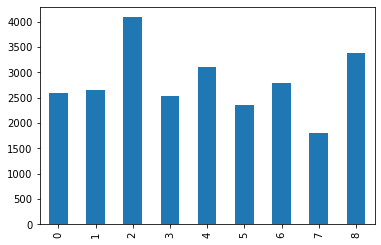

In [58]:
# Read data
df = pd.read_pickle(f'../data/pred_machining_process.pkl',compression='gzip')
display(df.head(3))
print(df.shape)
df['Machining_Process'].value_counts().sort_index().plot(kind='bar')


(2528, 50)


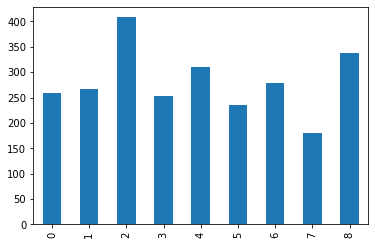

In [59]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Sample data (for experimenting)
df = df.groupby(by='Machining_Process').sample(frac=0.1, random_state=1)
print(df.shape)
df['Machining_Process'].value_counts().sort_index().plot(kind='bar')

# Extract data
colsX = np.array([item for item in df.columns if item not in 'Machining_Process'])
X = df[colsX].values
y = df['Machining_Process'].values

# Reduce no. of columns of ALL data
X = StandardScaler().fit_transform(X)
X = PCA(n_components=4).fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0, stratify=y)

# Benchmark using random forest

In [60]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestClassifier
forrest = RandomForestClassifier(criterion="gini", n_estimators=100, max_samples=None, max_features="auto", max_depth=None)

# Make scorer
scorer_ACC = make_scorer(accuracy_score)
scorer_PRE = make_scorer(precision_score, zero_division=0, average='weighted')
scorer_REC = make_scorer(recall_score, zero_division=0, average='weighted')
scorer_F1 = make_scorer(f1_score, average='weighted' )

scorings = {'accuracy':scorer_ACC,
            'precision':scorer_PRE,
            'recall': scorer_REC,
            'f1': scorer_F1,
            }

dataArrTrain = []
sc = cross_validate(estimator=forrest, X=X_train, y=y_train, cv=5, scoring=scorings, n_jobs=-1, error_score='raise')
ACC = sc['test_accuracy']
PRE = sc['test_precision']
REC = sc['test_recall']
F1 = sc['test_f1']

data = {'clf': 'RF',
        'ACC': f"{ACC.mean():6.3f}",
        'PRE': f"{PRE.mean():6.3f}",
        'REC': f"{REC.mean():6.3f}",
        'F1': f"{F1.mean():6.3f}"}

dataArrTrain.append(data)
dft = pd.DataFrame.from_records(dataArrTrain).set_index(["clf"])
display(dft)
            

,ACC,PRE,REC,F1
clf,,,,
RF,0.201,0.194,0.201,0.195


In [61]:
from sklearn.metrics import classification_report

# Not the right way to evaluate model during tuning because I am using test data.
forrest.fit(X_train, y_train)
y_pred = forrest.predict(X_test)
print(classification_report(y_test, y_pred, digits=4))

dataArrTest = []
# Store test performance
ACC = accuracy_score(y_true=y_test, y_pred=y_pred)
PRE = precision_score(y_true=y_test, y_pred=y_pred, zero_division=0, average='weighted')
REC = recall_score(y_true=y_test, y_pred=y_pred, zero_division=0, average='weighted')
F1 = f1_score(y_true=y_test, y_pred=y_pred, zero_division=0, average='weighted')
data = {'clf': f"RF (Test)",
        'ACC': f"{ACC:6.3f}",
        'PRE': f"{PRE:6.3f}",
        'REC': f"{REC:6.3f}",
        'F1': f"{F1:6.3f}"}
dataArrTest.append(data)
dft = pd.DataFrame.from_records(dataArrTest).set_index(["clf"])
display(dft)

              precision    recall  f1-score   support

           0     0.2308    0.1923    0.2098        78
           1     0.1970    0.1625    0.1781        80
           2     0.2679    0.3689    0.3103       122
           3     0.1692    0.1447    0.1560        76
           4     0.2105    0.2151    0.2128        93
           5     0.1852    0.2113    0.1974        71
           6     0.2258    0.1667    0.1918        84
           7     0.1053    0.0741    0.0870        54
           8     0.2185    0.2574    0.2364       101

    accuracy                         0.2148       759
   macro avg     0.2011    0.1992    0.1977       759
weighted avg     0.2091    0.2148    0.2092       759



,ACC,PRE,REC,F1
clf,,,,
RF (Test),0.215,0.209,0.215,0.209


# Voting Classifier

In [62]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

def runCV(clf, name, X_train, y_train, X_test, y_test, dataArr):
        scorer_ACC = make_scorer(accuracy_score)
        scorer_PRE = make_scorer(precision_score, zero_division=0, average='weighted')
        scorer_REC = make_scorer(recall_score, zero_division=0, average='weighted')
        scorer_F1 = make_scorer(f1_score, zero_division=0, average='weighted' )

        scorings = {'accuracy':scorer_ACC,
                'precision':scorer_PRE,
                'recall': scorer_REC,
                'f1': scorer_F1,
                }

        sc = cross_validate(estimator=clf, X=X_train, y=y_train, cv=5, scoring=scorings, n_jobs=-1, error_score='raise')
        ACC = sc['test_accuracy']
        PRE = sc['test_precision']
        REC = sc['test_recall']
        F1 = sc['test_f1']

        data = {'clf': name,
                'ACC': f"{ACC.mean():6.3f}",
                'PRE': f"{PRE.mean():6.3f}",
                'REC': f"{REC.mean():6.3f}",
                'F1': f"{F1.mean():6.3f}"}

        dataArr.append(data)
        dft = pd.DataFrame.from_records(dataArr).set_index(["clf"])
        return dataArr, dft

def runML(clf, name, params, X_train, y_train, X_test, y_test, dataArr):
        # Grid search
        gs = GridSearchCV(estimator=clf, param_grid=params, scoring='accuracy', cv=5, n_jobs=-1, verbose=0)
        # Searching
        gs.fit(X_train, y_train)
        # Print result
        print(gs.best_params_)
        print(gs.best_score_)
        # Print Test performance
        y_pred = gs.predict(X_test)
        print(classification_report(y_test, y_pred,  digits=4, zero_division=0))

        # Store test performance
        ACC = accuracy_score(y_true=y_test, y_pred=y_pred)
        PRE = precision_score(y_true=y_test, y_pred=y_pred, zero_division=0, average='weighted')
        REC = recall_score(y_true=y_test, y_pred=y_pred, zero_division=0, average='weighted')
        F1 = f1_score(y_true=y_test, y_pred=y_pred, zero_division=0, average='weighted')
        
        data = {'clf': f"{name} (Test)",
                'ACC': f"{ACC:6.3f}",
                'PRE': f"{PRE:6.3f}",
                'REC': f"{REC:6.3f}",
                'F1': f"{F1:6.3f}"}

        dataArr.append(data)
        dft = pd.DataFrame.from_records(dataArr).set_index(["clf"])
        return dataArr, dft

In [63]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.pipeline import Pipeline
from sklearn.ensemble import VotingClassifier

#Logistic regression
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=0)
pipe_lr = Pipeline([['sc', StandardScaler()], ['clf', clf1]])

# Decision tree
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
pipe_dt = Pipeline([['sc', StandardScaler()], ['clf', clf2]])

# KNN
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
pipe_knn = Pipeline([['sc', StandardScaler()], ['clf', clf3]])

# Voting classifier
estimators = [
    ('pipe_lr', pipe_lr),
    ('pipe_dt', pipe_dt),
    ('pipe_knn', pipe_knn)]

eclf = VotingClassifier(estimators=estimators, voting='soft')

In [64]:
# Not the right way to evaluate model during tuning because I am using test data.
#eclf.fit(X_train, y_train)
#y_pred = eclf.predict(X_test)
#print(classification_report(y_test, y_pred, digits=4))

In [65]:
clfs = [pipe_lr, pipe_dt, pipe_knn, eclf]
names = ['Logistic Regression', 'Decision Tree', 'K-Nearest Neighbor', 'Voting Classifier']

for clf, name in zip(clfs, names):
        dataArrTrain, dft = runCV(clf, name, X_train, y_train, X_test, y_test, dataArrTrain)
display(dft)

,ACC,PRE,REC,F1
clf,,,,
RF,0.201,0.194,0.201,0.195
Logistic Regression,0.162,0.026,0.162,0.045
Decision Tree,0.163,0.045,0.163,0.068
K-Nearest Neighbor,0.213,0.214,0.213,0.212
Voting Classifier,0.213,0.214,0.213,0.212


In [66]:
# Parameters
params = {'pipe_dt__clf__max_depth': [4, 6, None], 'pipe_lr__clf__C': [0.01, 0.1], 'pipe_knn__clf__n_neighbors': [4, 6]}
dataArrTest, dft = runML(eclf, 'VR', params, X_train, y_train, X_test, y_test, dataArrTest)
display(dft)

{'pipe_dt__clf__max_depth': 4, 'pipe_knn__clf__n_neighbors': 6, 'pipe_lr__clf__C': 0.1}
0.20634752964901332
              precision    recall  f1-score   support

           0     0.1642    0.1410    0.1517        78
           1     0.1667    0.1000    0.1250        80
           2     0.2782    0.5656    0.3730       122
           3     0.1915    0.1184    0.1463        76
           4     0.2727    0.2903    0.2812        93
           5     0.1333    0.0845    0.1034        71
           6     0.2222    0.1905    0.2051        84
           7     0.2500    0.1111    0.1538        54
           8     0.2294    0.2475    0.2381       101

    accuracy                         0.2332       759
   macro avg     0.2120    0.2054    0.1975       759
weighted avg     0.2171    0.2332    0.2128       759



,ACC,PRE,REC,F1
clf,,,,
RF (Test),0.215,0.209,0.215,0.209
VR (Test),0.233,0.217,0.233,0.213


# Bagging Classifier

In [67]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

base = DecisionTreeClassifier(criterion='entropy', max_depth=None, random_state=1)
bag = BaggingClassifier(base_estimator=base,
                        n_estimators=100, 
                        max_samples=1.0, #This results in the same number of observations as the original data.
                        max_features=1.0, #Use the same number of features as the original data.
                        bootstrap=True, #Sample are drawn with replacement.
                        bootstrap_features=False, #Feature are drawn without replcaement.
                        n_jobs=-1, 
                        random_state=1)

clfs = [bag]
names = ['Bagging']

for clf, name in zip(clfs, names):
        dataArrTrain, dft = runCV(clf, name, X_train, y_train, X_test, y_test, dataArrTrain)
display(dft)

,ACC,PRE,REC,F1
clf,,,,
RF,0.201,0.194,0.201,0.195
Logistic Regression,0.162,0.026,0.162,0.045
Decision Tree,0.163,0.045,0.163,0.068
K-Nearest Neighbor,0.213,0.214,0.213,0.212
Voting Classifier,0.213,0.214,0.213,0.212
Bagging,0.214,0.207,0.214,0.208


In [68]:
bag.get_params()

{'base_estimator__ccp_alpha': 0.0,
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'entropy',
 'base_estimator__max_depth': None,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__random_state': 1,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(criterion='entropy', random_state=1),
 'bootstrap': True,
 'bootstrap_features': False,
 'max_features': 1.0,
 'max_samples': 1.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'oob_score': False,
 'random_state': 1,
 'verbose': 0,
 'warm_start': False}

In [69]:
# Parameters
params = {'base_estimator__max_depth': [3, None], 'n_estimators': [50, 100]}
dataArrTest, dft = runML(bag, 'Bagging', params, X_train, y_train, X_test, y_test, dataArrTest)
display(dft)

{'base_estimator__max_depth': None, 'n_estimators': 100}
0.21425713416878728
              precision    recall  f1-score   support

           0     0.1892    0.1795    0.1842        78
           1     0.1667    0.1375    0.1507        80
           2     0.2771    0.3770    0.3194       122
           3     0.2059    0.1842    0.1944        76
           4     0.1474    0.1505    0.1489        93
           5     0.1690    0.1690    0.1690        71
           6     0.2500    0.1786    0.2083        84
           7     0.1667    0.1111    0.1333        54
           8     0.2520    0.3069    0.2768       101

    accuracy                         0.2148       759
   macro avg     0.2027    0.1994    0.1984       759
weighted avg     0.2091    0.2148    0.2091       759



,ACC,PRE,REC,F1
clf,,,,
RF (Test),0.215,0.209,0.215,0.209
VR (Test),0.233,0.217,0.233,0.213
Bagging (Test),0.215,0.209,0.215,0.209


# Adaboost Classifier

In [70]:
from sklearn.ensemble import AdaBoostClassifier

base = DecisionTreeClassifier(criterion='entropy', 
                              max_depth=1,
                              random_state=1)

ada = AdaBoostClassifier(base_estimator=base,
                         n_estimators=500, 
                         learning_rate=0.05,
                         random_state=1)
          
clfs = [ada]
names = ['AdaBoost']

for clf, name in zip(clfs, names):
        dataArrTrain, dft = runCV(clf, name, X_train, y_train, X_test, y_test, dataArrTrain)
display(dft)

,ACC,PRE,REC,F1
clf,,,,
RF,0.201,0.194,0.201,0.195
Logistic Regression,0.162,0.026,0.162,0.045
Decision Tree,0.163,0.045,0.163,0.068
K-Nearest Neighbor,0.213,0.214,0.213,0.212
Voting Classifier,0.213,0.214,0.213,0.212
Bagging,0.214,0.207,0.214,0.208
AdaBoost,0.179,0.153,0.179,0.135


In [71]:
ada.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator__ccp_alpha': 0.0,
 'base_estimator__class_weight': None,
 'base_estimator__criterion': 'entropy',
 'base_estimator__max_depth': 1,
 'base_estimator__max_features': None,
 'base_estimator__max_leaf_nodes': None,
 'base_estimator__min_impurity_decrease': 0.0,
 'base_estimator__min_impurity_split': None,
 'base_estimator__min_samples_leaf': 1,
 'base_estimator__min_samples_split': 2,
 'base_estimator__min_weight_fraction_leaf': 0.0,
 'base_estimator__random_state': 1,
 'base_estimator__splitter': 'best',
 'base_estimator': DecisionTreeClassifier(criterion='entropy', max_depth=1, random_state=1),
 'learning_rate': 0.05,
 'n_estimators': 500,
 'random_state': 1}

In [72]:
# Parameters
params = {'base_estimator__max_depth': [1, 2], 'n_estimators': [50, 100]}
dataArrTest, dft = runML(ada, 'Adaboost', params, X_train, y_train, X_test, y_test, dataArrTest)
display(dft)

{'base_estimator__max_depth': 2, 'n_estimators': 50}
0.1746658984331237
              precision    recall  f1-score   support

           0     0.1892    0.0897    0.1217        78
           1     0.0000    0.0000    0.0000        80
           2     0.1776    0.6885    0.2824       122
           3     0.0000    0.0000    0.0000        76
           4     0.1047    0.0968    0.1006        93
           5     0.0000    0.0000    0.0000        71
           6     0.2647    0.1071    0.1525        84
           7     0.0000    0.0000    0.0000        54
           8     0.1520    0.1881    0.1681       101

    accuracy                         0.1686       759
   macro avg     0.0987    0.1300    0.0917       759
weighted avg     0.1103    0.1686    0.1095       759



,ACC,PRE,REC,F1
clf,,,,
RF (Test),0.215,0.209,0.215,0.209
VR (Test),0.233,0.217,0.233,0.213
Bagging (Test),0.215,0.209,0.215,0.209
Adaboost (Test),0.169,0.110,0.169,0.109


# Gradient Boosting Classifier

In [74]:
from sklearn.ensemble import GradientBoostingClassifier

# Gradient Boosting Machine
gbm = GradientBoostingClassifier(loss='deviance',
                                learning_rate=0.1,
                                n_estimators=100,
                                min_samples_split=2, #The minimum number of samples required to split an internal node
                                min_samples_leaf=1, #The minimum number of samples required to be at a leaf node. 
                                max_depth=3 #The maximum depth of the individual regression estimators.
)

clfs = [gbm]
names = ['Gbm']

for clf, name in zip(clfs, names):
        dataArrTrain, dft = runCV(clf, name, X_train, y_train, X_test, y_test, dataArrTrain)
display(dft)

,ACC,PRE,REC,F1
clf,,,,
RF,0.201,0.194,0.201,0.195
Logistic Regression,0.162,0.026,0.162,0.045
Decision Tree,0.163,0.045,0.163,0.068
K-Nearest Neighbor,0.213,0.214,0.213,0.212
Voting Classifier,0.213,0.214,0.213,0.212
Bagging,0.214,0.207,0.214,0.208
AdaBoost,0.179,0.153,0.179,0.135
Gbm,0.174,0.169,0.174,0.167


In [75]:
gbm.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': None,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

In [77]:
# Parameters
params = {'max_depth': [3, None], 'n_estimators': [100]}
dataArrTest, dft = runML(gbm, 'Gbm', params, X_train, y_train, X_test, y_test, dataArrTest)
display(dft)

{'max_depth': None, 'n_estimators': 100}
0.18597013492101602
              precision    recall  f1-score   support

           0     0.2041    0.1282    0.1575        78
           1     0.1452    0.1125    0.1268        80
           2     0.2519    0.5328    0.3421       122
           3     0.1333    0.1053    0.1176        76
           4     0.2462    0.1720    0.2025        93
           5     0.1757    0.1831    0.1793        71
           6     0.2321    0.1548    0.1857        84
           7     0.1277    0.1111    0.1188        54
           8     0.1705    0.1485    0.1587       101

    accuracy                         0.2042       759
   macro avg     0.1874    0.1831    0.1766       759
weighted avg     0.1942    0.2042    0.1880       759



,ACC,PRE,REC,F1
clf,,,,
RF (Test),0.215,0.209,0.215,0.209
VR (Test),0.233,0.217,0.233,0.213
Bagging (Test),0.215,0.209,0.215,0.209
Adaboost (Test),0.169,0.110,0.169,0.109
Gbm (Test),0.204,0.194,0.204,0.188


# XGBoost Classifier

In [78]:
from xgboost import XGBClassifier

# XGBoost                    
xgb = XGBClassifier(eval_metric="logloss", use_label_encoder=False, n_estimators=100)

clfs = [xgb]
names = ['XGB']

for clf, name in zip(clfs, names):
        dataArrTrain, dft = runCV(clf, name, X_train, y_train, X_test, y_test, dataArrTrain)
display(dft)


,ACC,PRE,REC,F1
clf,,,,
RF,0.201,0.194,0.201,0.195
Logistic Regression,0.162,0.026,0.162,0.045
Decision Tree,0.163,0.045,0.163,0.068
K-Nearest Neighbor,0.213,0.214,0.213,0.212
Voting Classifier,0.213,0.214,0.213,0.212
Bagging,0.214,0.207,0.214,0.208
AdaBoost,0.179,0.153,0.179,0.135
Gbm,0.174,0.169,0.174,0.167
XGB,0.180,0.172,0.180,0.174


In [ ]:
xgb.get_params()

{'objective': 'binary:logistic',
 'use_label_encoder': False,
 'base_score': None,
 'booster': None,
 'colsample_bylevel': None,
 'colsample_bynode': None,
 'colsample_bytree': None,
 'enable_categorical': False,
 'gamma': None,
 'gpu_id': None,
 'importance_type': None,
 'interaction_constraints': None,
 'learning_rate': None,
 'max_delta_step': None,
 'max_depth': None,
 'min_child_weight': None,
 'missing': nan,
 'monotone_constraints': None,
 'n_estimators': 100,
 'n_jobs': None,
 'num_parallel_tree': None,
 'predictor': None,
 'random_state': None,
 'reg_alpha': None,
 'reg_lambda': None,
 'scale_pos_weight': None,
 'subsample': None,
 'tree_method': None,
 'validate_parameters': None,
 'verbosity': None,
 'eval_metric': 'logloss'}

In [79]:
# Parameters
params = {'max_depth': [20], 'gamma': [0], 'eta': [0.05], 'n_estimators': [100]}
dataArrTest, dft = runML(xgb, 'XGB', params, X_train, y_train, X_test, y_test, dataArrTest)
display(dft)

{'eta': 0.05, 'gamma': 0, 'max_depth': 20, 'n_estimators': 100}
0.1938957443062691
              precision    recall  f1-score   support

           0     0.2308    0.1923    0.2098        78
           1     0.2157    0.1375    0.1679        80
           2     0.2816    0.4016    0.3311       122
           3     0.1370    0.1316    0.1342        76
           4     0.1702    0.1720    0.1711        93
           5     0.1370    0.1408    0.1389        71
           6     0.2698    0.2024    0.2313        84
           7     0.0625    0.0556    0.0588        54
           8     0.1610    0.1881    0.1735       101

    accuracy                         0.1976       759
   macro avg     0.1851    0.1802    0.1796       759
weighted avg     0.1948    0.1976    0.1928       759



,ACC,PRE,REC,F1
clf,,,,
RF (Test),0.215,0.209,0.215,0.209
VR (Test),0.233,0.217,0.233,0.213
Bagging (Test),0.215,0.209,0.215,0.209
Adaboost (Test),0.169,0.110,0.169,0.109
Gbm (Test),0.204,0.194,0.204,0.188
XGB (Test),0.198,0.195,0.198,0.193


# LightGBM

In [82]:
from lightgbm import LGBMClassifier

lgb = LGBMClassifier(n_estimators=100)

clfs = [lgb]
names = ['LGB']

for clf, name in zip(clfs, names):
        dataArrTrain, dft = runCV(clf, name, X_train, y_train, X_test, y_test, dataArrTrain)
display(dft)


,ACC,PRE,REC,F1
clf,,,,
RF,0.201,0.194,0.201,0.195
Logistic Regression,0.162,0.026,0.162,0.045
Decision Tree,0.163,0.045,0.163,0.068
K-Nearest Neighbor,0.213,0.214,0.213,0.212
Voting Classifier,0.213,0.214,0.213,0.212
Bagging,0.214,0.207,0.214,0.208
AdaBoost,0.179,0.153,0.179,0.135
Gbm,0.174,0.169,0.174,0.167
XGB,0.180,0.172,0.180,0.174


In [ ]:
lgb.get_params()

{'boosting_type': 'gbdt',
 'class_weight': None,
 'colsample_bytree': 1.0,
 'importance_type': 'split',
 'learning_rate': 0.1,
 'max_depth': -1,
 'min_child_samples': 20,
 'min_child_weight': 0.001,
 'min_split_gain': 0.0,
 'n_estimators': 100,
 'n_jobs': -1,
 'num_leaves': 31,
 'objective': None,
 'random_state': None,
 'reg_alpha': 0.0,
 'reg_lambda': 0.0,
 'silent': True,
 'subsample': 1.0,
 'subsample_for_bin': 200000,
 'subsample_freq': 0}

In [83]:
# Parameters
params = {'max_depth': [-1], 'n_estimators': [100]}
dataArrTest, dft = runML(lgb, 'LGB', params, X_train, y_train, X_test, y_test, dataArrTest)
display(dft)

{'max_depth': -1, 'n_estimators': 100}
0.1831548790832413
              precision    recall  f1-score   support

           0     0.2540    0.2051    0.2270        78
           1     0.1714    0.1500    0.1600        80
           2     0.2961    0.3689    0.3285       122
           3     0.1549    0.1447    0.1497        76
           4     0.1414    0.1505    0.1458        93
           5     0.1341    0.1549    0.1438        71
           6     0.2500    0.1667    0.2000        84
           7     0.0800    0.0741    0.0769        54
           8     0.1897    0.2178    0.2028       101

    accuracy                         0.1963       759
   macro avg     0.1857    0.1814    0.1816       759
weighted avg     0.1957    0.1963    0.1939       759



,ACC,PRE,REC,F1
clf,,,,
RF (Test),0.215,0.209,0.215,0.209
VR (Test),0.233,0.217,0.233,0.213
Bagging (Test),0.215,0.209,0.215,0.209
Adaboost (Test),0.169,0.110,0.169,0.109
Gbm (Test),0.204,0.194,0.204,0.188
XGB (Test),0.198,0.195,0.198,0.193
LGB (Test),0.196,0.196,0.196,0.194
